In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [2]:

from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize
from accelerate import Accelerator

import itertools
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from pathlib import Path
import torch
from torchvision.transforms import Compose, PILToTensor
from torch.utils.data import DataLoader
import numpy as np
import os

import lovely_tensors as lt
lt.monkey_patch()

from label_anything.models import build_lam_no_vit
from label_anything.experiment.substitution import Substitutor
from label_anything.data.examples import uniform_sampling
from label_anything.data import utils
from label_anything.data.utils import AnnFileKeys, PromptType, BatchKeys

%load_ext autoreload
%autoreload 2

Helper functions

In [3]:
from notebooks.visualize import *

In [4]:
pdir = Path.cwd().parent

Dataset definition

In [5]:
IMG_DIR = "/ext/stalla/LabelAnything/images/train2017"
ANNOTATIONS_DIR = os.path.join(pdir, "data/annotations/instances_val2017.json")
EMBEDDINGS_DIR = "/ext/stalla/LabelAnything/embeddings"


In [6]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [7]:
dataset = LabelAnythingDataset(
    {
        "coco": {
            "name": "coco",
            "instances_path": ANNOTATIONS_DIR,
            "img_dir": IMG_DIR,
            "preprocess": preprocess,
        }
    }, {}
)
coco_dataset = dataset.datasets["coco"]
accelerator = Accelerator()
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 8], [1, 4], [1, 2], [1, 1]],
        num_processes=1,
        shuffle=False,
)
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)
dataloader = accelerator.prepare(dataloader)
iter_data = iter(dataloader)

Loading dataset annotations from /home/pasquale/projects/LabelAnything/data/annotations/instances_val2017.json...


---
Load model

In [8]:
model = build_lam_no_vit(
    spatial_convs=3,
)
model = accelerator.prepare(model)

Load weights

In [9]:
run_id = "4pdvxpgy"
load_checkpoint(accelerator, run_id)

[2024-02-11 17:20:12] INFO - logging.py - Loading states from best
[2024-02-11 17:20:12] INFO - logging.py - All model weights loaded successfully
[2024-02-11 17:20:12] INFO - logging.py - All optimizer states loaded successfully
[2024-02-11 17:20:12] INFO - logging.py - All scheduler states loaded successfully
[2024-02-11 17:20:12] INFO - logging.py - All dataloader sampler states loaded successfully
[2024-02-11 17:20:12] INFO - logging.py - Could not load random states
[2024-02-11 17:20:12] INFO - logging.py - Loading in 0 custom states


---

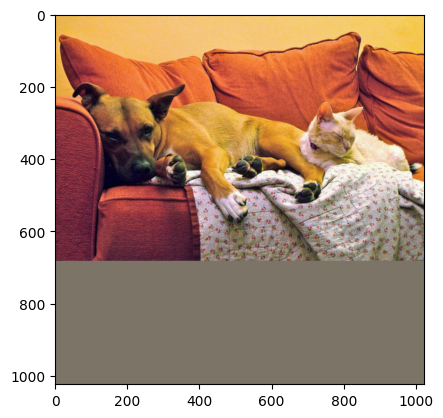

In [75]:
idx = 34
num_examples = 4
base_image_data = coco_dataset.images[coco_dataset.image_ids[idx]]

fig = plt.imshow(get_image(coco_dataset._load_and_preprocess_image(base_image_data)))

img_cats = torch.tensor(list(coco_dataset.img2cat[base_image_data[AnnFileKeys.ID]]))
sampled_classes = (
    coco_dataset.example_generator.sample_classes_from_query(img_cats, uniform_sampling)
    if coco_dataset.do_subsample
    else img_cats
)
toggle_classes = {
    widgets.ToggleButton(description=coco_dataset.categories[cat.item()]["name"], value=True): cat for cat in img_cats
}
row_classes = widgets.HBox(list(toggle_classes.keys()))
display(row_classes)

In [77]:
sampled_classes = [cat for toggle, cat in toggle_classes.items() if toggle.value]
print([coco_dataset.categories[cat.item()]["name"] for cat in sampled_classes])

['cat', 'dog', 'couch']


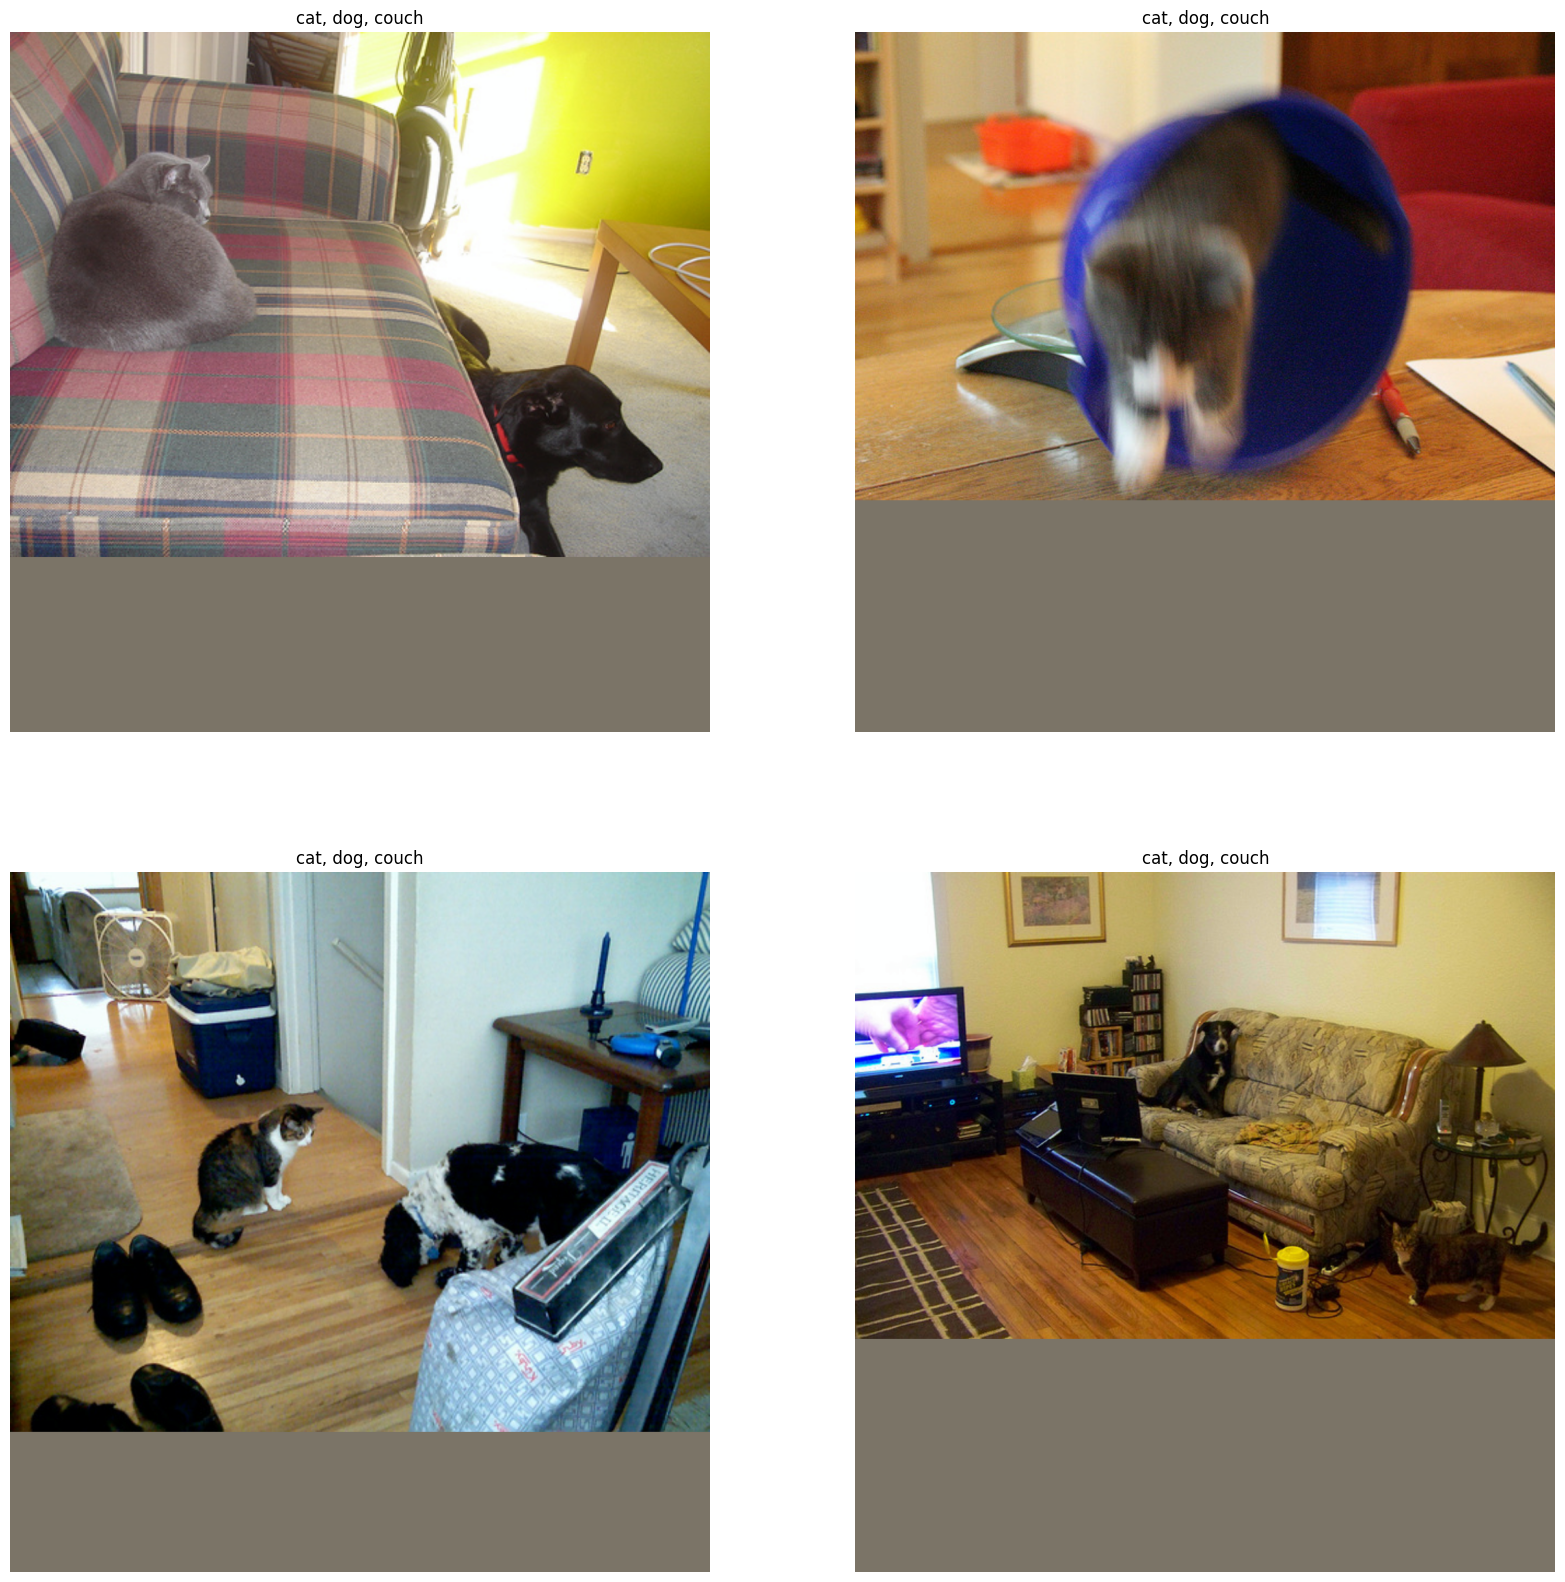

In [78]:
image_ids, aux_cat_ids =  coco_dataset.example_generator.generate_examples(
    query_image_id=base_image_data[AnnFileKeys.ID],
    image_classes=img_cats,
    sampled_classes=torch.tensor(sampled_classes),
    num_examples=num_examples,
)

cat_ids = list(set(itertools.chain(*aux_cat_ids)))
cat_ids.insert(0, -1)  # add the background class

images, image_key, ground_truths = coco_dataset._get_images_or_embeddings(image_ids)

pil_images = [get_image(image) for image in images][1:]

plot_images(pil_images, aux_cat_ids, coco_dataset.categories)

In [84]:
options = {PromptType.BBOX, PromptType.MASK, PromptType.POINT}
toggle_prompts = {widgets.ToggleButton(description=option, value=True): option for option in options}
buttons_row = widgets.HBox(list(toggle_prompts.keys()))
display(buttons_row)

In [131]:
prompt_types = [option for toggle, option in toggle_prompts.items() if toggle.value]
print(prompt_types)

[<PromptType.MASK: 'mask'>]


In [132]:
bboxes, masks, points, classes, img_sizes = coco_dataset._get_prompts(
    image_ids, cat_ids, prompt_types
)

In [133]:
(batch, gt), dataset_name = obtain_batch(dataset, coco_dataset, images, image_ids, cat_ids, classes, img_sizes, image_key, (bboxes, masks, points), ground_truths=None)

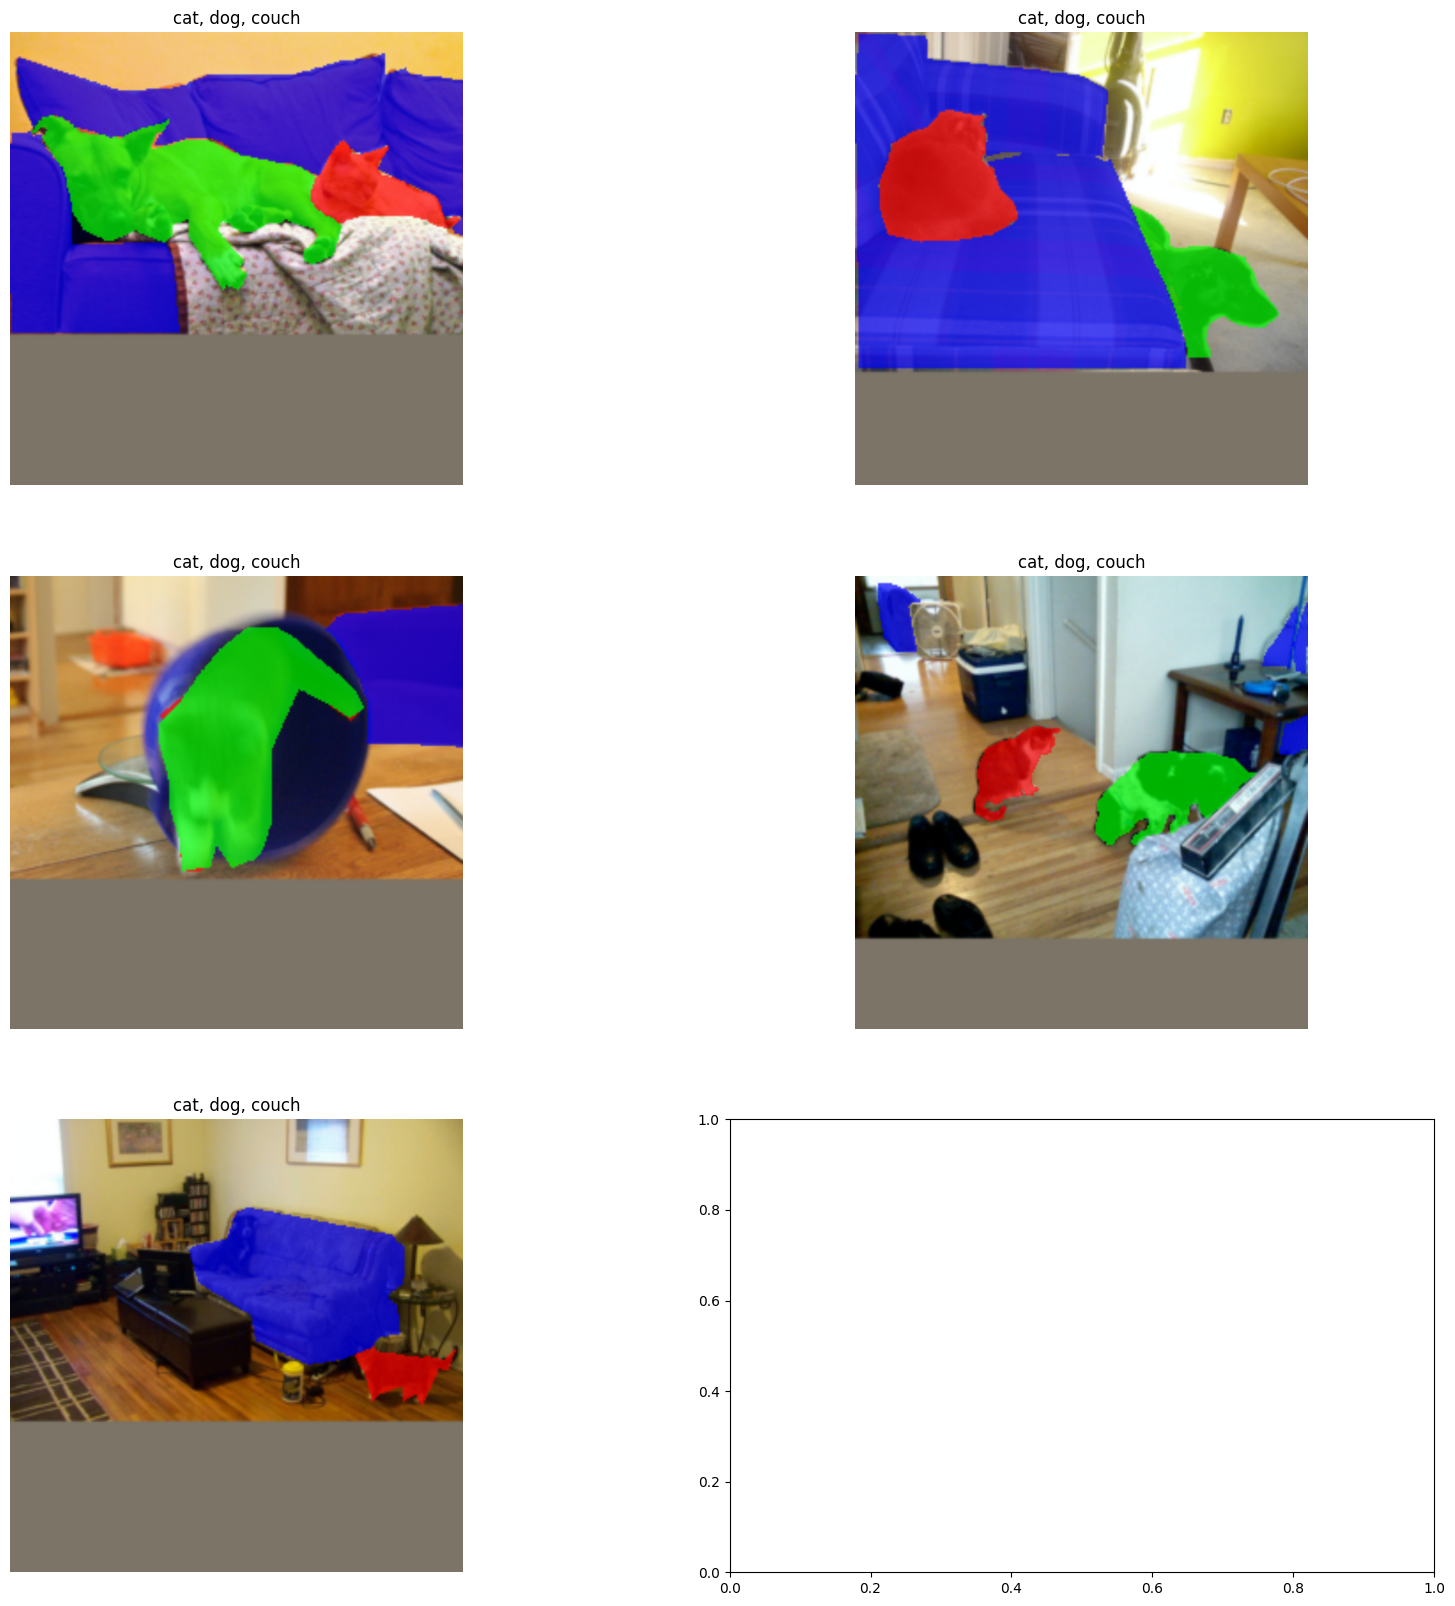

In [134]:
plot_all(dataset, batch, colors)

In [124]:
get_embeddings_names(batch, EMBEDDINGS_DIR)

In [125]:
batch = set_embeddings(accelerator, batch, EMBEDDINGS_DIR)
batch = to_device(batch, accelerator.device)

 Load the substitutor

In [126]:
substitutor = Substitutor(substitute=False)
substitutor.reset((batch, gt))
input, one_gt = next(iter(substitutor))

In [127]:
with torch.no_grad():
    seg = model(input)

In [128]:
logits = seg['logits']
examples_class_embeddings = seg['class_examples_embeddings']
class_embeddings = examples_class_embeddings.mean(dim=1)

seg = logits.argmax(dim=1)

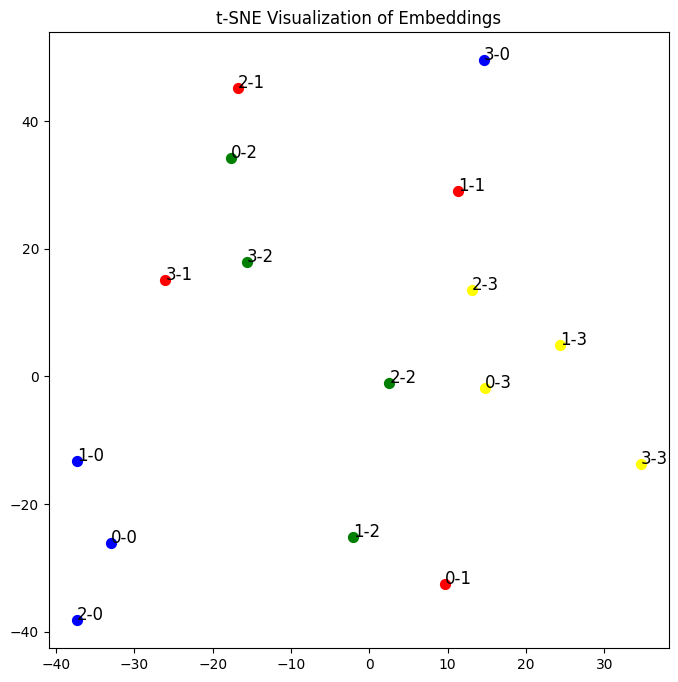

In [129]:
plot_emebddings(examples_class_embeddings, input['flag_examples'], text_colors)

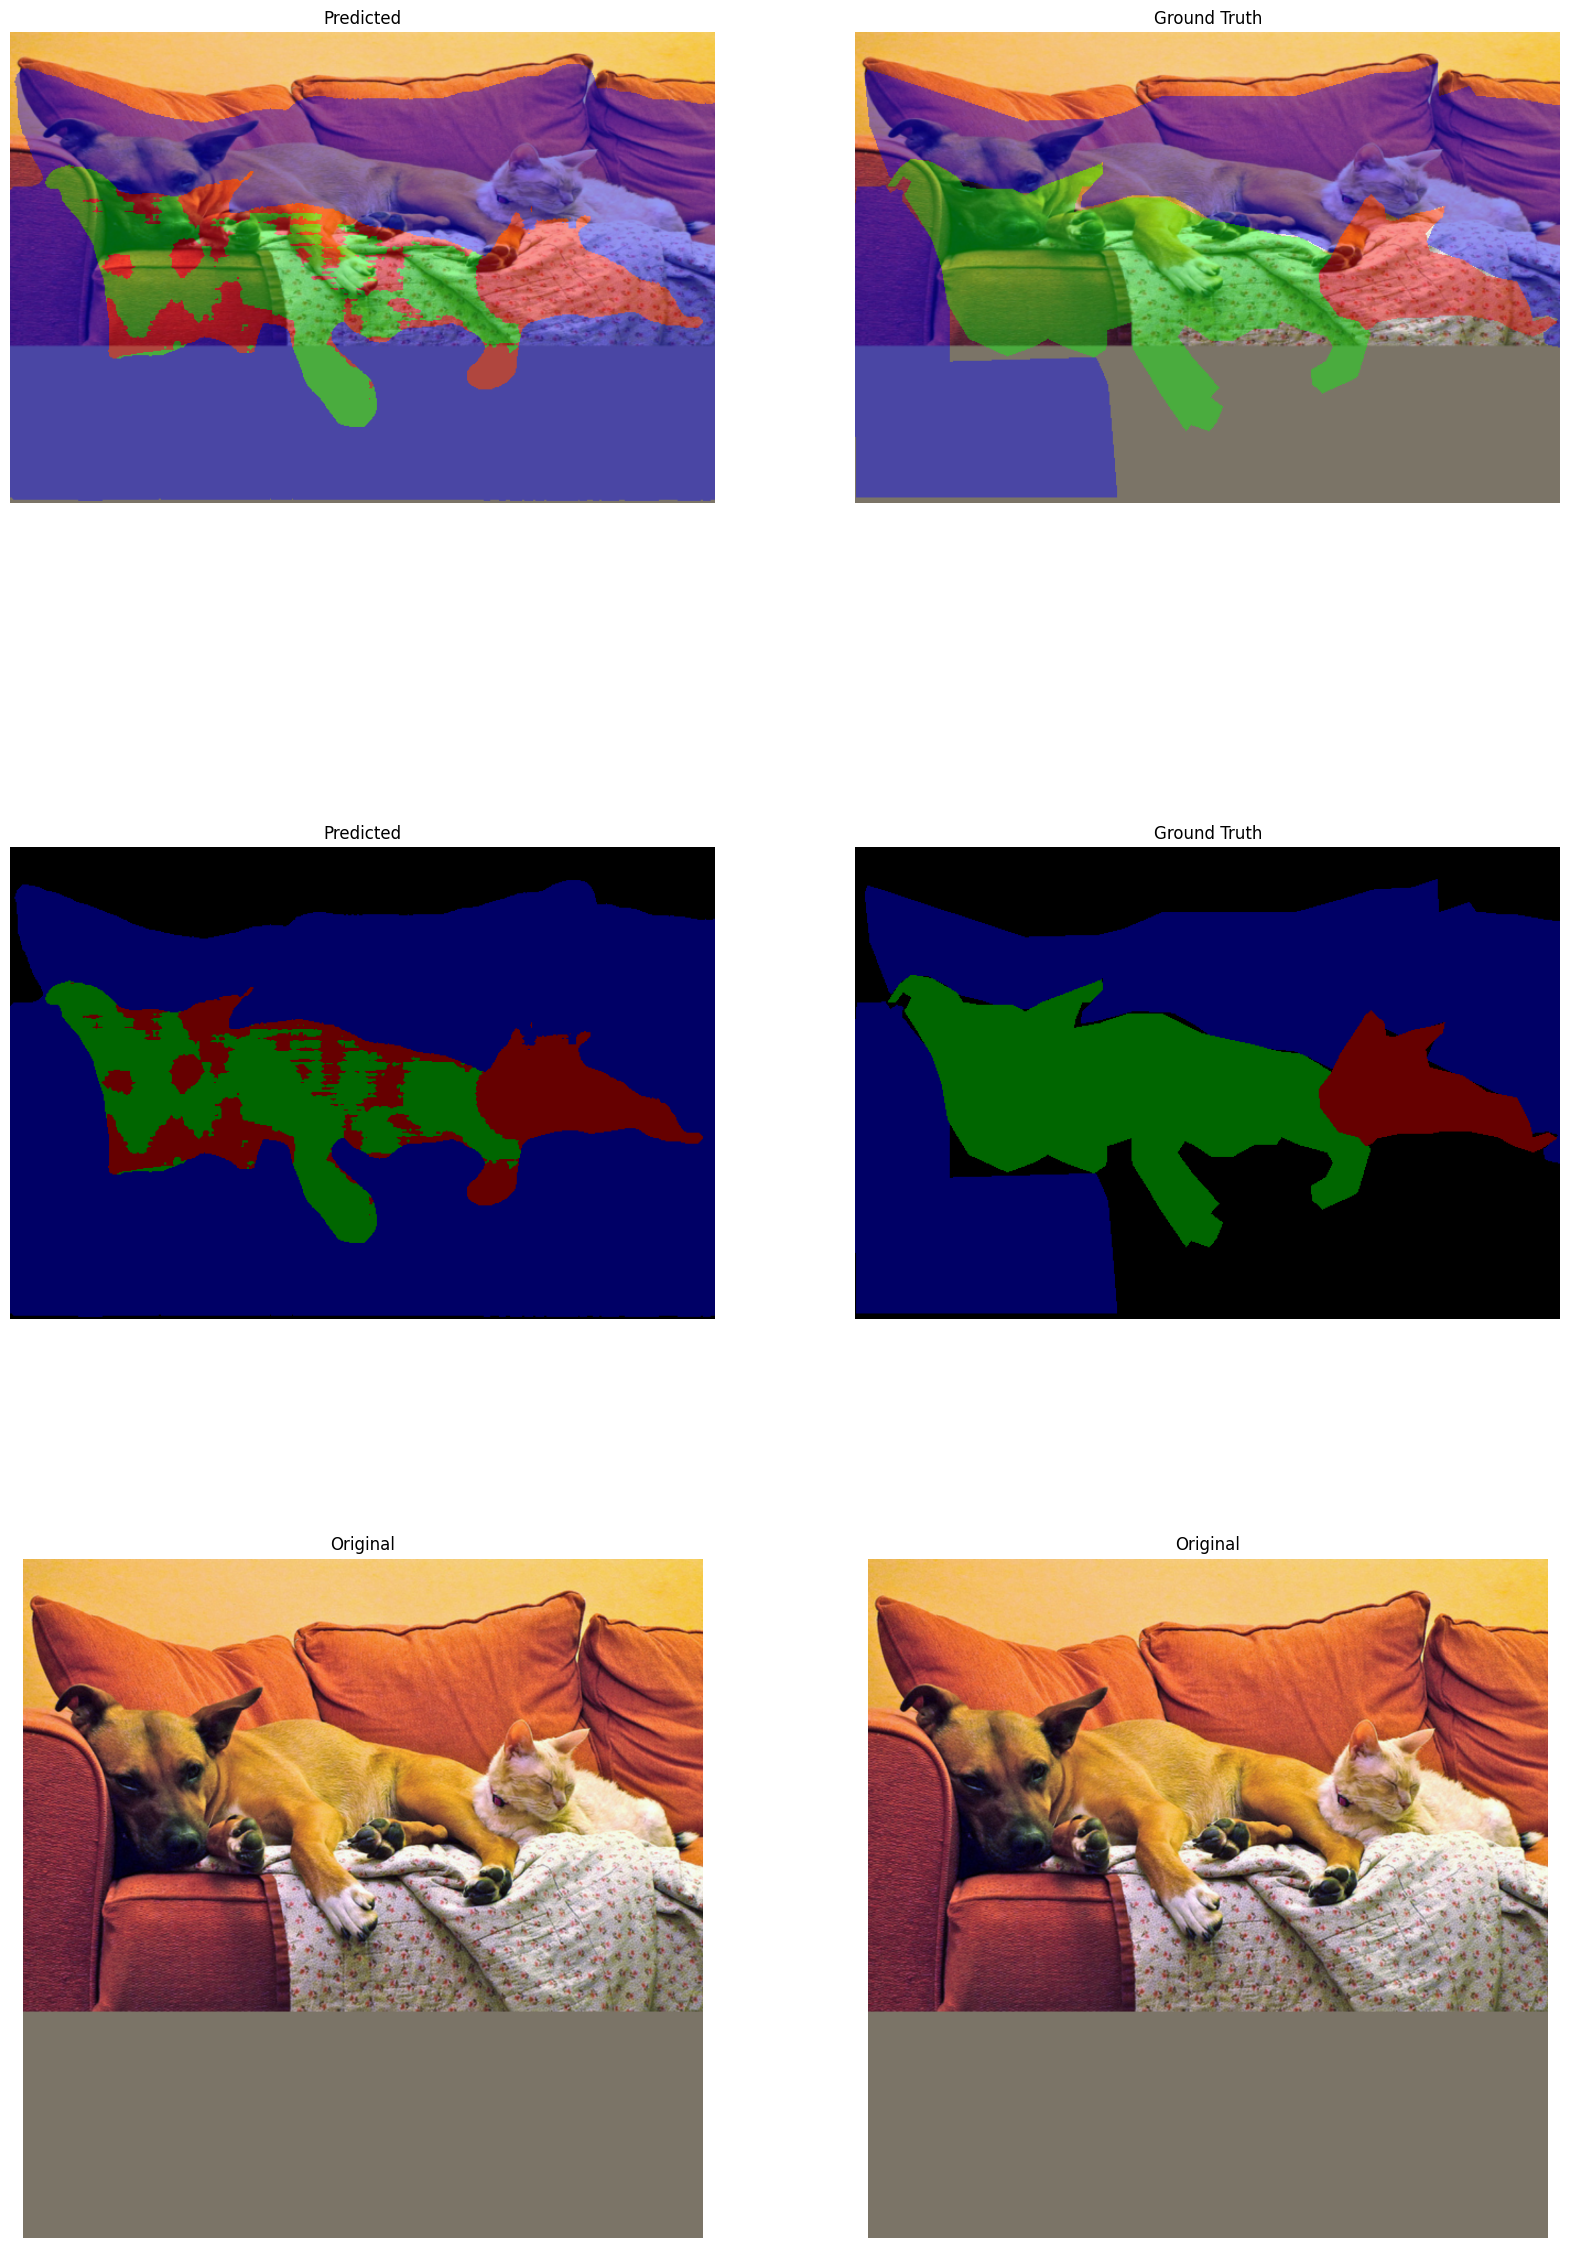

In [130]:
plot_segs(input, seg, one_gt, colors)